## Import Relevant Files

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import json

import sys
sys.path.insert(1, '../utils')
from paths import *

sys.path.insert(1, '../models')
from feedforward_nn_combined import NeuralNetworkCombined

import chromadb

## Load Music Metadata

In [2]:
df_music = pd.read_csv("./music_info_withname.csv")
df_music.rename(columns={"i_id_c": "song_id"}, inplace=True)
df_music = df_music.astype({'song_id': 'int32'})

cols = ["song_id", "general_genre", "music", "singer"]
df_music = df_music[cols]
display(df_music)

,song_id,general_genre,music,singer
0,874,indie,The Privateers,Andrew Bird
1,566,other,Never Stops,Deerhunter
2,812,jazz,Night Of The Iguana,The Cinematic Orchestra
3,941,rock,You And Me,Plain White T's
4,802,reggae,Saber Su Nombre,Daddy Yankee
...,...,...,...,...
931,438,rock,Uptown Girl,Me First And The Gimme Gimmes
932,690,other,Oblivious,Aztec Camera
933,163,alternative,America's Suitehearts,Fall Out Boy
934,946,metal,Ride The Lightning,Metallica


## Load Essentia Features

In [3]:
df_features = pd.read_csv("./essentia_features_clipped.csv", index_col=0)
display(df_features)

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,metadata.version.essentia_git_sha,metadata.version.extractor,tonal.chords_key,tonal.chords_scale,tonal.key_edma.key,tonal.key_edma.scale,tonal.key_krumhansl.key,tonal.key_krumhansl.scale,tonal.key_temperley.key,tonal.key_temperley.scale
0,275,0.973211,2.734494,4.519869,6.629131,17.751158,22.156931,9.782679,9.064570,2.926671,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,Bb,major,Eb,major,Eb,major,Eb,major
1,507,0.914995,1.779870,2.783498,2.342016,5.451638,24.106762,11.063436,10.109395,3.955993,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,F#,major,F#,major,F#,major,F#,major
2,936,0.980768,2.198826,3.604454,6.320270,16.075104,21.427538,7.163894,6.297218,2.519053,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,Ab,major,C#,major,C#,major,C#,major
3,739,0.957888,2.358258,3.890606,5.011153,12.956815,24.700670,15.441179,15.776317,4.622088,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,A,major,D,minor,D,minor,D,minor
4,659,0.985889,2.725301,4.472162,7.312916,17.942963,19.204697,7.446805,6.570291,2.597616,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,E,major,E,major,E,major,E,major
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,126,0.981803,3.347317,5.755877,9.081094,23.494911,24.453768,9.621816,8.968574,2.641244,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,B,major,C,major,C,major,C,major
292,898,0.968436,2.509090,4.032299,6.231036,16.421440,23.289955,12.805885,12.573533,3.175924,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,G,major,D,major,D,major,D,major
293,873,0.944901,3.191716,5.233109,9.425733,24.588820,26.887018,9.700563,8.773985,2.415689,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,E,minor,E,minor,E,minor,E,minor
294,697,0.979438,2.086719,3.368903,5.024929,12.668143,23.188427,7.980445,7.247404,2.558759,...,v2.1_beta5-1110-g77a6a954-dirty,music 2.0,F#,minor,D,major,D,major,D,major


In [4]:
df_features.columns.tolist()

['song_id',
 'lowlevel.average_loudness',
 'lowlevel.barkbands_crest.dmean',
 'lowlevel.barkbands_crest.dmean2',
 'lowlevel.barkbands_crest.dvar',
 'lowlevel.barkbands_crest.dvar2',
 'lowlevel.barkbands_crest.max',
 'lowlevel.barkbands_crest.mean',
 'lowlevel.barkbands_crest.median',
 'lowlevel.barkbands_crest.min',
 'lowlevel.barkbands_crest.stdev',
 'lowlevel.barkbands_crest.var',
 'lowlevel.barkbands_flatness_db.dmean',
 'lowlevel.barkbands_flatness_db.dmean2',
 'lowlevel.barkbands_flatness_db.dvar',
 'lowlevel.barkbands_flatness_db.dvar2',
 'lowlevel.barkbands_flatness_db.max',
 'lowlevel.barkbands_flatness_db.mean',
 'lowlevel.barkbands_flatness_db.median',
 'lowlevel.barkbands_flatness_db.min',
 'lowlevel.barkbands_flatness_db.stdev',
 'lowlevel.barkbands_flatness_db.var',
 'lowlevel.barkbands_kurtosis.dmean',
 'lowlevel.barkbands_kurtosis.dmean2',
 'lowlevel.barkbands_kurtosis.dvar',
 'lowlevel.barkbands_kurtosis.dvar2',
 'lowlevel.barkbands_kurtosis.max',
 'lowlevel.barkbands_k

In [5]:
with open("../models/essentia_best_overall_normalised/config.json") as file:
    config = json.load(file)

In [6]:
from pprint import pprint

pprint(config["columns"])

['lowlevel.melbands_kurtosis.mean',
 'lowlevel.melbands_skewness.mean',
 'lowlevel.spectral_energy.mean',
 'tonal.chords_strength.mean',
 'tonal.hpcp_entropy.mean',
 'tonal.key_edma.strength',
 'tonal.key_temperley.strength',
 'rhythm.beats_loudness_band_ratio.mean_0',
 'rhythm.beats_loudness_band_ratio.mean_1',
 'rhythm.beats_loudness_band_ratio.mean_2',
 'rhythm.beats_loudness_band_ratio.mean_3',
 'rhythm.beats_loudness_band_ratio.mean_4',
 'rhythm.beats_loudness_band_ratio.mean_5',
 'tonal.chords_histogram_0',
 'tonal.chords_histogram_1',
 'tonal.chords_histogram_2',
 'tonal.chords_histogram_3',
 'tonal.chords_histogram_4',
 'tonal.chords_histogram_5',
 'tonal.chords_histogram_6',
 'tonal.chords_histogram_7',
 'tonal.chords_histogram_8',
 'tonal.chords_histogram_9',
 'tonal.chords_histogram_10',
 'tonal.chords_histogram_11',
 'tonal.chords_histogram_12',
 'tonal.chords_histogram_13',
 'tonal.chords_histogram_14',
 'tonal.chords_histogram_15',
 'tonal.chords_histogram_16',
 'tonal.ch

In [7]:
columns_list = config["columns"].copy()
for i in range(len(columns_list)):
    for j in range(25, -1, -1):
        columns_list[i] = columns_list[i].replace(f"_{str(j)}", "")

columns_list = list(set(columns_list))
pprint(columns_list)

['tonal.key_edma.strength',
 'tonal.hpcp_entropy.mean',
 'tonal.key_temperley.strength',
 'lowlevel.spectral_energy.mean',
 'tonal.chords_strength.mean',
 'tonal.chords_histogram',
 'lowlevel.melbands_kurtosis.mean',
 'rhythm.beats_loudness_band_ratio.mean',
 'lowlevel.melbands_skewness.mean']


In [8]:
combined_cols = ["song_id"] + columns_list
df_features = df_features[combined_cols]
display(df_features)

,song_id,tonal.key_edma.strength,tonal.hpcp_entropy.mean,tonal.key_temperley.strength,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.chords_histogram,lowlevel.melbands_kurtosis.mean,rhythm.beats_loudness_band_ratio.mean,lowlevel.melbands_skewness.mean
0,275,0.831445,2.157470,0.817991,0.026425,0.515836,[13.292117 9.119011 39.412674 6.027820...,8.703437,[0.6488103 0.13547923 0.06808347 0.084613 0...,2.212965
1,507,0.867256,1.291610,0.842389,0.025474,0.584794,[70.06173 16.97531 8.641975 0. ...,5.770704,[0.29111102 0.37667215 0.2311264 0.1415846 0...,1.455347
2,936,0.761910,1.797165,0.772563,0.030572,0.522387,[20.092735 5.718702 31.37558 0.154559...,6.409736,[0.39313012 0.09728278 0.19740573 0.08137493 0...,2.125510
3,739,0.572999,1.721073,0.594957,0.041455,0.480624,[ 2.1638331 0. 4.482226 2.318392...,10.689654,[6.8727541e-01 2.4049108e-01 8.9235857e-02 8.6...,2.175458
4,659,0.610119,2.079940,0.568450,0.028688,0.515830,[27.777779 2.1604939 19.753086 0.308641...,4.815639,[0.29895017 0.20722117 0.13490912 0.1010152 0...,2.069900
...,...,...,...,...,...,...,...,...,...,...
291,126,0.770802,2.060801,0.792550,0.030396,0.473093,[13.580247 1.2345679 12.345679 7.0987654 ...,7.398580,[0.29474336 0.21356685 0.26888177 0.17496932 0...,1.859779
292,898,0.516840,2.056412,0.532360,0.043833,0.444209,[22.411129 0. 1.2364761 4.482226 1...,53.474087,[0.6591388 0.1896384 0.01527784 0.01759173 0...,4.824572
293,873,0.723064,2.195538,0.702887,0.027678,0.567833,[34.389584 13.97691 2.5300908 2.652911...,12.378922,[0.40409413 0.4042216 0.13770425 0.09644146 0...,2.631586
294,697,0.808841,1.973732,0.811848,0.030046,0.548445,[23.338486 24.111282 16.846987 1.854714...,6.976427,[0.5169765 0.09072314 0.09417467 0.09538271 0...,2.258094


In [9]:
df_features.dtypes

song_id                                    int64
tonal.key_edma.strength                  float64
tonal.hpcp_entropy.mean                  float64
tonal.key_temperley.strength             float64
lowlevel.spectral_energy.mean            float64
tonal.chords_strength.mean               float64
tonal.chords_histogram                    object
lowlevel.melbands_kurtosis.mean          float64
rhythm.beats_loudness_band_ratio.mean     object
lowlevel.melbands_skewness.mean          float64
dtype: object

In [10]:
from preprocessing import essentia_features_string_to_ndarray, essentia_flatten_columns

In [11]:
df_features["rhythm.beats_loudness_band_ratio.mean"] = df_features["rhythm.beats_loudness_band_ratio.mean"].apply(essentia_features_string_to_ndarray)
df_features["tonal.chords_histogram"] = df_features["tonal.chords_histogram"].apply(essentia_features_string_to_ndarray)

display(df_features)

,song_id,tonal.key_edma.strength,tonal.hpcp_entropy.mean,tonal.key_temperley.strength,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.chords_histogram,lowlevel.melbands_kurtosis.mean,rhythm.beats_loudness_band_ratio.mean,lowlevel.melbands_skewness.mean
0,275,0.831445,2.157470,0.817991,0.026425,0.515836,"[13.292117, 9.119011, 39.412674, 6.0278206, 0....",8.703437,"[0.6488103, 0.13547923, 0.06808347, 0.084613, ...",2.212965
1,507,0.867256,1.291610,0.842389,0.025474,0.584794,"[70.06173, 16.97531, 8.641975, 0.0, 0.0, 0.0, ...",5.770704,"[0.29111102, 0.37667215, 0.2311264, 0.1415846,...",1.455347
2,936,0.761910,1.797165,0.772563,0.030572,0.522387,"[20.092735, 5.718702, 31.37558, 0.15455951, 0....",6.409736,"[0.39313012, 0.09728278, 0.19740573, 0.0813749...",2.125510
3,739,0.572999,1.721073,0.594957,0.041455,0.480624,"[2.1638331, 0.0, 4.482226, 2.3183925, 9.891808...",10.689654,"[0.68727541, 0.24049108, 0.089235857, 0.008607...",2.175458
4,659,0.610119,2.079940,0.568450,0.028688,0.515830,"[27.777779, 2.1604939, 19.753086, 0.30864197, ...",4.815639,"[0.29895017, 0.20722117, 0.13490912, 0.1010152...",2.069900
...,...,...,...,...,...,...,...,...,...,...
291,126,0.770802,2.060801,0.792550,0.030396,0.473093,"[13.580247, 1.2345679, 12.345679, 7.0987654, 0...",7.398580,"[0.29474336, 0.21356685, 0.26888177, 0.1749693...",1.859779
292,898,0.516840,2.056412,0.532360,0.043833,0.444209,"[22.411129, 0.0, 1.2364761, 4.482226, 13.29211...",53.474087,"[0.6591388, 0.1896384, 0.01527784, 0.01759173,...",4.824572
293,873,0.723064,2.195538,0.702887,0.027678,0.567833,"[34.389584, 13.97691, 2.5300908, 2.652911, 0.0...",12.378922,"[0.40409413, 0.4042216, 0.13770425, 0.09644146...",2.631586
294,697,0.808841,1.973732,0.811848,0.030046,0.548445,"[23.338486, 24.111282, 16.846987, 1.854714, 13...",6.976427,"[0.5169765, 0.09072314, 0.09417467, 0.09538271...",2.258094


In [12]:
df_chords = essentia_flatten_columns(df_features, "tonal.chords_histogram")
display(df_chords)

tonal.chords_histogram


,tonal.chords_histogram_0,tonal.chords_histogram_1,tonal.chords_histogram_2,tonal.chords_histogram_3,tonal.chords_histogram_4,tonal.chords_histogram_5,tonal.chords_histogram_6,tonal.chords_histogram_7,tonal.chords_histogram_8,tonal.chords_histogram_9,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,13.292117,9.119011,39.412674,6.027821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.309119,0.000000,12.828439,0.000000,2.472952,7.882535,1.545595,4.636785,2.472952
1,70.061730,16.975310,8.641975,0.000000,0.000000,0.000000,0.000000,0.000000,4.320988,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,20.092735,5.718702,31.375580,0.154560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.309119,0.000000,13.137558,0.000000,1.391036,25.811438,1.391036
3,2.163833,0.000000,4.482226,2.318392,9.891808,0.000000,24.111282,2.163833,0.000000,27.666151,...,0.309119,0.000000,6.800618,5.873261,0.309119,0.618238,0.000000,2.318392,0.000000,3.400309
4,27.777779,2.160494,19.753086,0.308642,13.580247,0.000000,1.543210,2.160494,27.160494,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.555555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,13.580247,1.234568,12.345679,7.098765,0.000000,5.246913,3.086420,0.000000,0.000000,0.000000,...,2.469136,0.000000,0.000000,2.469136,0.000000,1.234568,0.000000,1.543210,7.716049,4.938271
292,22.411129,0.000000,1.236476,4.482226,13.292117,6.646059,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.391036,0.000000,7.882535,10.819165,4.636785,24.111282,3.091190
293,34.389584,13.976910,2.530091,2.652911,0.000000,0.466716,1.793171,18.816015,0.171948,0.000000,...,0.638664,0.147384,0.122820,0.196512,1.424711,1.473839,1.424711,4.667158,6.705969,7.467453
294,23.338486,24.111282,16.846987,1.854714,13.755796,0.000000,1.236476,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.491499,0.000000,0.000000,0.000000,1.236476,10.355487,0.463678


In [13]:
df_loudness_ratio = essentia_flatten_columns(df_features, "rhythm.beats_loudness_band_ratio.mean")
display(df_loudness_ratio)

rhythm.beats_loudness_band_ratio.mean


,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,rhythm.beats_loudness_band_ratio.mean_3,rhythm.beats_loudness_band_ratio.mean_4,rhythm.beats_loudness_band_ratio.mean_5
0,0.648810,0.135479,0.068083,0.084613,0.080677,0.039263
1,0.291111,0.376672,0.231126,0.141585,0.006126,0.003038
2,0.393130,0.097283,0.197406,0.081375,0.091061,0.164489
3,0.687275,0.240491,0.089236,0.008608,0.001783,0.000056
4,0.298950,0.207221,0.134909,0.101015,0.142889,0.193513
...,...,...,...,...,...,...
291,0.294743,0.213567,0.268882,0.174969,0.099864,0.041727
292,0.659139,0.189638,0.015278,0.017592,0.049573,0.130759
293,0.404094,0.404222,0.137704,0.096441,0.067066,0.075851
294,0.516976,0.090723,0.094175,0.095383,0.122425,0.104366


In [14]:
df_features2 = df_features.drop(columns=["tonal.chords_histogram", "rhythm.beats_loudness_band_ratio.mean"], axis=1)

df_features3 = pd.concat([df_features2, df_chords, df_loudness_ratio], axis=1, join="inner")
# df_features3 = df_features2.join(df_chords)
# df_features3 = df_features3.join(df_loudness_ratio)

cols = ["song_id"] + config["columns"]
df_features3  = df_features3[cols]
display(df_features3)

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,275,8.703437,2.212965,0.026425,0.515836,2.157470,0.831445,0.817991,0.648810,0.135479,...,0.000000,0.309119,0.000000,12.828439,0.000000,2.472952,7.882535,1.545595,4.636785,2.472952
1,507,5.770704,1.455347,0.025474,0.584794,1.291610,0.867256,0.842389,0.291111,0.376672,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,936,6.409736,2.125510,0.030572,0.522387,1.797165,0.761910,0.772563,0.393130,0.097283,...,0.000000,0.000000,0.000000,0.309119,0.000000,13.137558,0.000000,1.391036,25.811438,1.391036
3,739,10.689654,2.175458,0.041455,0.480624,1.721073,0.572999,0.594957,0.687275,0.240491,...,0.309119,0.000000,6.800618,5.873261,0.309119,0.618238,0.000000,2.318392,0.000000,3.400309
4,659,4.815639,2.069900,0.028688,0.515830,2.079940,0.610119,0.568450,0.298950,0.207221,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.555555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,126,7.398580,1.859779,0.030396,0.473093,2.060801,0.770802,0.792550,0.294743,0.213567,...,2.469136,0.000000,0.000000,2.469136,0.000000,1.234568,0.000000,1.543210,7.716049,4.938271
292,898,53.474087,4.824572,0.043833,0.444209,2.056412,0.516840,0.532360,0.659139,0.189638,...,0.000000,0.000000,0.000000,1.391036,0.000000,7.882535,10.819165,4.636785,24.111282,3.091190
293,873,12.378922,2.631586,0.027678,0.567833,2.195538,0.723064,0.702887,0.404094,0.404222,...,0.638664,0.147384,0.122820,0.196512,1.424711,1.473839,1.424711,4.667158,6.705969,7.467453
294,697,6.976427,2.258094,0.030046,0.548445,1.973732,0.808841,0.811848,0.516976,0.090723,...,0.000000,0.000000,0.000000,6.491499,0.000000,0.000000,0.000000,1.236476,10.355487,0.463678


In [15]:
df_combined = df_music.merge(df_features3, how="inner", on="song_id")
display(df_combined)

,song_id,general_genre,music,singer,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,874,indie,The Privateers,Andrew Bird,35.427742,3.579856,0.022717,0.587754,1.855739,0.869044,...,0.000000,2.887020,0.000000,2.614230,0.159127,7.729029,0.000000,0.954762,7.456240,17.231190
1,812,jazz,Night Of The Iguana,The Cinematic Orchestra,26.031311,3.134115,0.035748,0.447074,1.903557,0.710809,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.463678,0.000000
2,941,rock,You And Me,Plain White T's,16.693066,2.697692,0.031357,0.509351,1.939108,0.779920,...,0.000000,0.000000,0.927357,9.737248,0.000000,12.364760,0.927357,14.528593,6.336940,5.873261
3,739,metal,Planet Caravan,Black Sabbath,10.689654,2.175458,0.041455,0.480624,1.721073,0.572999,...,0.309119,0.000000,6.800618,5.873261,0.309119,0.618238,0.000000,2.318392,0.000000,3.400309
4,70,reggae,No Creo En El Jamas,Juanes,32.218643,3.736483,0.039212,0.472139,1.795459,0.770797,...,0.000000,1.854714,0.000000,3.863988,0.000000,4.173107,0.000000,0.618238,19.629057,13.137558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,47,rock,The Stomp,The Hives,8.976665,2.380176,0.032531,0.621645,2.491951,0.742576,...,0.647249,0.000000,0.283172,0.121359,0.000000,0.000000,0.000000,0.000000,11.771845,0.768608
292,529,hip-hop,Where The Hood At,DMX,18.355627,2.690892,0.032824,0.510858,1.986281,0.648383,...,0.000000,0.000000,0.000000,0.000000,5.246913,0.000000,0.000000,0.000000,0.000000,0.000000
293,875,alternative,Sullen Girl,Fiona Apple,7.889258,2.193920,0.038098,0.548003,2.003608,0.725705,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.012346,0.000000
294,946,metal,Ride The Lightning,Metallica,3.209861,1.584695,0.020797,0.615232,1.971868,0.819323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.310665


## Load Scaler

In [16]:
scaler_fpath = config["scaler"]
# print(scaler_fpath)
scaler_fpath = scaler_fpath.replace(".", "../..", 1)
scaler = joblib.load(scaler_fpath) #MinMaxScaler

## Load Neural Network

In [17]:
input_size = len(config["columns"])
print(input_size)
weights_fpath = config["model_weights"]
weights_fpath = weights_fpath.replace(".", "../..", 1)

model = NeuralNetworkCombined(input_size)
model.load_state_dict(torch.load(weights_fpath))

37


<All keys matched successfully>

In [18]:
inputs_normalised = scaler.transform(df_combined[config["columns"]].values)
inputs = torch.tensor(inputs_normalised).float()
print(inputs)

tensor([[0.0384, 0.2356, 0.0344,  ..., 0.0155, 0.0941, 0.1769],
        [0.0283, 0.2124, 0.0601,  ..., 0.0000, 0.0059, 0.0000],
        [0.0183, 0.1897, 0.0514,  ..., 0.2359, 0.0800, 0.0603],
        ...,
        [0.0088, 0.1636, 0.0647,  ..., 0.0000, 0.0507, 0.0000],
        [0.0038, 0.1319, 0.0306,  ..., 0.0000, 0.0000, 0.1777],
        [0.0138, 0.1939, 0.0465,  ..., 0.1604, 0.0000, 0.0000]])


/Users/issacj/Desktop/Personal/SUTD/School Year/Year 3/Term 6/50.038 Computational Data Science/Project/CDeeS/env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [19]:
preds = model(inputs)
print(preds)

tensor([[ 6.1448e-02,  6.1525e-02],
        [-4.9603e-02, -7.3350e-02],
        [ 1.6185e-01,  1.7831e-01],
        [-2.3912e-01, -2.6553e-01],
        [ 6.7223e-02,  6.7499e-02],
        [ 3.0595e-01,  3.5579e-01],
        [-1.9111e-01, -1.6306e-01],
        [-1.0844e-02, -2.4208e-02],
        [ 4.5052e-01,  5.1963e-01],
        [ 3.1904e-01,  3.6606e-01],
        [-8.9556e-02, -1.0309e-01],
        [-5.1905e-02, -7.6258e-02],
        [ 3.5768e-01,  4.5351e-01],
        [ 6.1348e-02,  6.1349e-02],
        [ 3.0624e-01,  3.5044e-01],
        [ 3.5176e-02,  3.1176e-02],
        [-2.4023e-01, -2.7082e-01],
        [ 4.0876e-03, -5.1069e-03],
        [ 2.0804e-01,  2.7942e-01],
        [-1.9501e-01, -2.1670e-01],
        [ 3.7008e-01,  4.2392e-01],
        [ 2.4990e-01,  2.8117e-01],
        [ 5.3628e-02,  5.5266e-02],
        [ 3.2009e-01,  3.6647e-01],
        [-1.2486e-01, -1.5667e-01],
        [-2.1937e-01, -2.4836e-01],
        [ 1.8512e-01,  2.0903e-01],
        [ 1.1219e-01,  1.266

In [20]:
min_val = torch.min(preds)
max_val = torch.max(preds)
print(min_val, max_val)

tensor(-68.4501, grad_fn=<MinBackward1>) tensor(0.5969, grad_fn=<MaxBackward1>)


In [21]:
preds = torch.clamp(preds, min=-1, max=1)

In [22]:
# Pretend to keep only VA values - Used dummy variables instead
df_combined["valence_pred"] = preds[:, 0].detach().numpy()
df_combined["arousal_pred"] = preds[:, 1].detach().numpy()
display(df_combined)

,song_id,general_genre,music,singer,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_pred,arousal_pred
0,874,indie,The Privateers,Andrew Bird,35.427742,3.579856,0.022717,0.587754,1.855739,0.869044,...,0.000000,2.614230,0.159127,7.729029,0.000000,0.954762,7.456240,17.231190,0.061448,0.061525
1,812,jazz,Night Of The Iguana,The Cinematic Orchestra,26.031311,3.134115,0.035748,0.447074,1.903557,0.710809,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.463678,0.000000,-0.049603,-0.073350
2,941,rock,You And Me,Plain White T's,16.693066,2.697692,0.031357,0.509351,1.939108,0.779920,...,0.927357,9.737248,0.000000,12.364760,0.927357,14.528593,6.336940,5.873261,0.161849,0.178305
3,739,metal,Planet Caravan,Black Sabbath,10.689654,2.175458,0.041455,0.480624,1.721073,0.572999,...,6.800618,5.873261,0.309119,0.618238,0.000000,2.318392,0.000000,3.400309,-0.239124,-0.265528
4,70,reggae,No Creo En El Jamas,Juanes,32.218643,3.736483,0.039212,0.472139,1.795459,0.770797,...,0.000000,3.863988,0.000000,4.173107,0.000000,0.618238,19.629057,13.137558,0.067223,0.067499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,47,rock,The Stomp,The Hives,8.976665,2.380176,0.032531,0.621645,2.491951,0.742576,...,0.283172,0.121359,0.000000,0.000000,0.000000,0.000000,11.771845,0.768608,0.124370,0.141292
292,529,hip-hop,Where The Hood At,DMX,18.355627,2.690892,0.032824,0.510858,1.986281,0.648383,...,0.000000,0.000000,5.246913,0.000000,0.000000,0.000000,0.000000,0.000000,0.032270,0.031995
293,875,alternative,Sullen Girl,Fiona Apple,7.889258,2.193920,0.038098,0.548003,2.003608,0.725705,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.012346,0.000000,0.112424,0.118159
294,946,metal,Ride The Lightning,Metallica,3.209861,1.584695,0.020797,0.615232,1.971868,0.819323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.310665,0.347791,0.403387


In [23]:
df_va = df_combined[["valence_pred", "arousal_pred"]].copy()
display(df_va.values.tolist())

[[0.06144779920578003, 0.06152521073818207],
 [-0.04960320144891739, -0.07334983348846436],
 [0.16184896230697632, 0.1783054918050766],
 [-0.2391241490840912, -0.265527606010437],
 [0.06722251325845718, 0.06749854981899261],
 [0.305948942899704, 0.3557863235473633],
 [-0.19110643863677979, -0.16305570304393768],
 [-0.01084417849779129, -0.024207770824432373],
 [0.45051905512809753, 0.5196318030357361],
 [0.31904423236846924, 0.3660629391670227],
 [-0.08955588936805725, -0.10309161990880966],
 [-0.05190470069646835, -0.07625758647918701],
 [0.357684463262558, 0.45350801944732666],
 [0.06134837120771408, 0.06134916841983795],
 [0.30624479055404663, 0.35044461488723755],
 [0.03517628461122513, 0.031176403164863586],
 [-0.24023115634918213, -0.27082347869873047],
 [0.004087585955858231, -0.005106911063194275],
 [0.20804381370544434, 0.2794223427772522],
 [-0.1950124204158783, -0.21670053899288177],
 [0.3700762689113617, 0.42392492294311523],
 [0.2498970329761505, 0.28117066621780396],
 [0.

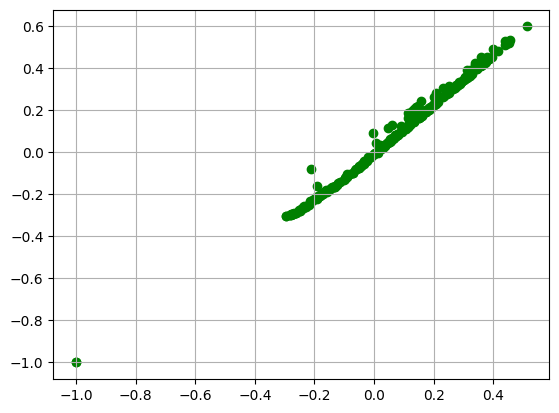

In [41]:
plt.scatter(df_combined["valence_pred"], df_combined["arousal_pred"], c="green")
plt.grid(True)
plt.show()

In [24]:
metadata = df_combined.columns.tolist()[1:4]
# print(metadata)
metadata_dicts = df_combined[metadata].to_dict('records')
# print(metadata_dicts)

In [25]:
song_ids = df_combined["song_id"].values.tolist()
print(song_ids)

[874, 812, 941, 739, 70, 987, 5, 300, 720, 266, 576, 6, 876, 360, 912, 74, 158, 239, 965, 276, 373, 550, 984, 905, 578, 170, 604, 204, 325, 361, 818, 268, 490, 258, 680, 506, 600, 26, 923, 699, 627, 558, 205, 17, 629, 594, 327, 13, 136, 673, 914, 175, 223, 532, 520, 14, 182, 480, 397, 634, 754, 120, 707, 23, 962, 514, 863, 422, 868, 790, 409, 995, 289, 544, 439, 414, 972, 297, 264, 826, 428, 727, 603, 649, 706, 126, 795, 192, 169, 591, 202, 372, 282, 822, 911, 24, 499, 947, 209, 228, 283, 329, 208, 977, 168, 796, 20, 333, 149, 934, 97, 341, 174, 975, 111, 759, 269, 723, 144, 384, 994, 429, 954, 222, 835, 843, 390, 621, 104, 672, 19, 117, 786, 418, 440, 886, 925, 320, 652, 936, 411, 90, 207, 897, 807, 216, 736, 731, 57, 780, 793, 924, 465, 46, 719, 565, 709, 752, 937, 516, 375, 951, 142, 883, 67, 469, 388, 619, 555, 356, 609, 635, 548, 996, 878, 518, 442, 367, 726, 957, 741, 76, 100, 784, 659, 43, 872, 206, 676, 363, 22, 974, 285, 81, 743, 816, 916, 523, 9, 677, 132, 233, 364, 862, 491,

In [26]:
song_ids_str = [str(x) for x in song_ids]
print(song_ids_str)

['874', '812', '941', '739', '70', '987', '5', '300', '720', '266', '576', '6', '876', '360', '912', '74', '158', '239', '965', '276', '373', '550', '984', '905', '578', '170', '604', '204', '325', '361', '818', '268', '490', '258', '680', '506', '600', '26', '923', '699', '627', '558', '205', '17', '629', '594', '327', '13', '136', '673', '914', '175', '223', '532', '520', '14', '182', '480', '397', '634', '754', '120', '707', '23', '962', '514', '863', '422', '868', '790', '409', '995', '289', '544', '439', '414', '972', '297', '264', '826', '428', '727', '603', '649', '706', '126', '795', '192', '169', '591', '202', '372', '282', '822', '911', '24', '499', '947', '209', '228', '283', '329', '208', '977', '168', '796', '20', '333', '149', '934', '97', '341', '174', '975', '111', '759', '269', '723', '144', '384', '994', '429', '954', '222', '835', '843', '390', '621', '104', '672', '19', '117', '786', '418', '440', '886', '925', '320', '652', '936', '411', '90', '207', '897', '807', 

## Chroma Vector Database

In [27]:
client = chromadb.Client()

## Persistent store
# client = chromadb.PersistentClient(path="./db/")

client.heartbeat()


1712497165271156000

In [28]:
# https://docs.trychroma.com/usage-guide#changing-the-distance-function
collection = client.create_collection(
        name="SiTunes_dataset",
        metadata={"hnsw:space": "l2"} # "l2", "ip" or "cosine"
    )

In [29]:
collection.add(
    documents=[f"song_{i}" for i in song_ids_str], # file_path
    embeddings=df_va.values.tolist(), # VA embeddings
    metadatas=metadata_dicts, # song_names
    ids=song_ids_str # song_id from SiTunes dataset
)

In [30]:
# Set number of results to return
k = 3

In [31]:
collection.query(
    query_embeddings=[[1, 1]], # search by embeddings
    n_results=k, # number of results
    # where={"metadata_field": "is_equal_to_this"}, # filter on metadata, e.g. genre
    # where_document={"$contains":"search_string"} # filter on file path???
    # include=["distances", "metadatas", "embeddings", "documents", "uris", "data"] # Need to include all relevant parameters to show
    include=["distances", "metadatas", "embeddings"]
)

{'ids': [['468', '676', '172']],
 'distances': [[0.4008080065250397, 0.5142097473144531, 0.5243784785270691]],
 'metadatas': [[{'general_genre': 'rock',
    'music': "Livin' On A Prayer",
    'singer': 'Bon Jovi'},
   {'general_genre': 'pop',
    'music': 'My Happy Ending',
    'singer': 'Avril Lavigne'},
   {'general_genre': 'metal',
    'music': 'Are You Dead Yet',
    'singer': 'Children Of Bodom'}]],
 'embeddings': [[[0.5118194818496704, 0.5969022512435913],
   [0.4565568268299103, 0.5321547389030457],
   [0.45254555344581604, 0.5260041356086731]]],
 'documents': None,
 'uris': None,
 'data': None}

In [32]:
collection.query(
    query_embeddings=[[-1, -1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings"]
)

{'ids': [['925', '591', '367']],
 'distances': [[0.0, 0.0, 0.9795432686805725]],
 'metadatas': [[{'general_genre': 'country',
    'music': "Devil's Spoke",
    'singer': 'Laura Marling'},
   {'general_genre': 'other', 'music': 'Old Song', 'singer': 'Max Richter'},
   {'general_genre': 'electronic',
    'music': 'Chameleon',
    'singer': 'Trentemøller'}]],
 'embeddings': [[[-1.0, -1.0],
   [-1.0, -1.0],
   [-0.29540032148361206, -0.3049585521221161]]],
 'documents': None,
 'uris': None,
 'data': None}

In [33]:
collection.query(
    query_embeddings=[[-1, 1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings"]
)

{'ids': [['85', '108', '390']],
 'distances': [[1.7873473167419434, 1.8264210224151611, 1.877483606338501]],
 'metadatas': [[{'general_genre': 'other',
    'music': 'Sessed One Night',
    'singer': 'Redman'},
   {'general_genre': 'hip-hop',
    'music': 'Dr. Bombay',
    'singer': 'Del Tha Funkee Homosapien'},
   {'general_genre': 'rnb',
    'music': 'Candy Rain',
    'singer': 'Soul For Real'}]],
 'embeddings': [[[-0.21055418252944946, -0.07894513010978699],
   [-0.0022136978805065155, 0.08849380910396576],
   [0.04509821534156799, 0.11385469138622284]]],
 'documents': None,
 'uris': None,
 'data': None}

In [34]:
collection.query(
    query_embeddings=[[1, -1]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings"]
)

{'ids': [['793', '6', '812']],
 'distances': [[1.9545336961746216, 1.959803581237793, 1.9603474140167236]],
 'metadatas': [[{'general_genre': 'rock',
    'music': 'Bala Bay Inn',
    'singer': 'Valley of the Giants'},
   {'general_genre': 'rock',
    'music': 'Have A Little Faith In Me',
    'singer': 'John Hiatt'},
   {'general_genre': 'jazz',
    'music': 'Night Of The Iguana',
    'singer': 'The Cinematic Orchestra'}]],
 'embeddings': [[[-0.06957550346851349, -0.09969901293516159],
   [-0.05190470069646835, -0.07625758647918701],
   [-0.04960320144891739, -0.07334983348846436]]],
 'documents': None,
 'uris': None,
 'data': None}

In [35]:
collection.query(
    query_embeddings=[[0, 0]], # search by embeddings
    n_results=k, # number of results
    include=["distances", "metadatas", "embeddings"]
)

{'ids': [['239', '471', '742']],
 'distances': [[4.278889900888316e-05,
   4.571857789414935e-05,
   6.225339893717319e-05]],
 'metadatas': [[{'general_genre': 'alternative',
    'music': 'Let Me Kiss You',
    'singer': 'Morrissey'},
   {'general_genre': 'rock', 'music': 'Alone Again Or', 'singer': 'Love'},
   {'general_genre': 'rnb',
    'music': 'Distance And Time',
    'singer': 'Alicia Keys'}]],
 'embeddings': [[[0.004087585955858231, -0.005106911063194275],
   [0.0023837238550186157, -0.006327435374259949],
   [-0.0016651153564453125, -0.007712379097938538]]],
 'documents': None,
 'uris': None,
 'data': None}